In [97]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from xgboost import XGBClassifier
from b2w_reviews import text_process, models


datetime.now().strftime("%d/%m/%Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'06/03/2023 18:54:59'

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)

pd.options.plotting.backend = "plotly"

In [3]:
df = pd.read_csv(r"data\B2W-Reviews01.csv", low_memory=False)

df[:5]

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


# Preprocessing

In [4]:
df = (
    df
    # assumir somente duas classes para serem avaliadas.
    .assign(overall_rating=lambda df: df["overall_rating"].map({1: 0, 2: 0, 3: 1, 4: 1, 5: 1}))
    
    # remove duplicates
    .drop_duplicates(subset=["reviewer_id"], keep="first")
    .fillna({
        "product_name": "-", 
        "review_title": "-",
        "review_text": "-",
    })
    # concat text columns
    .assign(texts=lambda df: df[["product_name", "review_title", "review_text"]].agg(' '.join, axis=1))
    .assign(review_text_preprocessed=lambda df: df["texts"].apply(text_process.clean_text))
    .assign(review_text_preprocessed=lambda df: text_process.remove_punctuation(df["review_text_preprocessed"]))
    .assign(review_text_preprocessed=lambda df: text_process.remove_stopwords(df["review_text_preprocessed"]))
    .assign(review_text_preprocessed=lambda df: text_process.stemming(df["review_text_preprocessed"]))
    .assign(review_text_preprocessed_tokens=lambda df: text_process.tokenize(df["review_text_preprocessed"]))    
)

df[:5]

2023-03-06 15:43:23,570 - b2w_reviews.logs - INFO - Running remove_punctuation
2023-03-06 15:43:25,282 - b2w_reviews.logs - INFO - Finished remove_punctuation
2023-03-06 15:43:25,407 - b2w_reviews.logs - INFO - Running remove_stopwords
2023-03-06 15:43:30,061 - b2w_reviews.logs - INFO - Finished remove_stopwords
2023-03-06 15:43:30,211 - b2w_reviews.logs - INFO - Running stemming
2023-03-06 15:44:21,507 - b2w_reviews.logs - INFO - Finished stemming
2023-03-06 15:44:21,650 - b2w_reviews.logs - INFO - Running tokenize
2023-03-06 15:44:36,770 - b2w_reviews.logs - INFO - Finished tokenize


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,texts,review_text_preprocessed,review_text_preprocessed_tokens
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,1,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ,Notebook Asus Vivobook Max X541NA-GO472T Intel...,notebook asu vivobook max x541nago472t intel c...,"[notebook, asu, vivobook, max, x541nago472t, i..."
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",1,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC,Copo Acrílico Com Canudo 500ml Rocie Preço imb...,copo acrílico canudo 500ml roci preço imbatíve...,"[copo, acrílico, canudo, 500ml, roci, preço, i..."
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,1,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP,Panela de Pressão Elétrica Philips Walita Dail...,panela pressão elétrica philip walita daili 5l...,"[panela, pressão, elétrica, philip, walita, da..."
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,1,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP,Betoneira Columbus - Roma Brinquedos presente ...,betoneira columbu roma brinquedo present desej...,"[betoneira, columbu, roma, brinquedo, present,..."
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",1,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",smart tv led 43 lg 43uj6525 ultra hd 4k conver...,"[smart, tv, led, 43, lg, 43uj6525, ultra, hd, ..."


In [5]:
df["overall_rating"].value_counts(normalize=True)

1    0.603356
0    0.396644
Name: overall_rating, dtype: float64

In [6]:
df["overall_rating"].isnull().mean()

0.0

# Split dataframe

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["review_text_preprocessed"], df["overall_rating"], test_size=0.30, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=1)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(79095,)
(16949,)
(16949,)


# vectorizer

In [70]:
# count_vectorizer = CountVectorizer(ngram_range = (1, 2))

# X_train_vectorizer = count_vectorizer.fit_transform(X_train.values)

# X_train_vectorizer.shape

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_vectorizer = vectorizer.fit_transform(X_train)

X_train_vectorizer.shape

(79095, 709965)

# Modelos

In [11]:
models.classifiers.keys()

dict_keys(['MultinomialNB', 'RandomForestClassifier', 'XGBClassifier'])

In [111]:
clf_multinomialnb = models.classifiers["MultinomialNB"]
clf_randomforestclassifier = models.classifiers["RandomForestClassifier"]
clf_XGBClassifier = models.classifiers["XGBClassifier"]

clf_multinomialnb.fit(X_train, y_train.values)
clf_randomforestclassifier.fit(X_train, y_train.values)
clf_XGBClassifier.fit(X_train, y_train.values)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [14]:
check_predictions = (
    X_val
    .to_frame()
    .assign(y=lambda df: y_val)
    .assign(predict=lambda df: clf_XGBClassifier.predict(X_val))
)

check_predictions[:5]

,review_text_preprocessed,y,predict
100870,triciclo aro 5 you 3 girl nathor bom produto e...,1,1
62811,tablet samsung galaxi tab t280 8gb wifi tela 7...,1,1
63700,cafeteira elétrica arno filtro cafp 4 12 xícar...,0,1
103823,smartphon motorola moto g 5s dual chip android...,1,1
71655,livro coquetéi 100 melhor receita ótimo produt...,1,1


In [15]:
(
    check_predictions
    .pipe(lambda df: df[df["y"] == 1])
    .pipe(lambda df: df[df["predict"] == 1])
    ["review_text_preprocessed"]
    .iloc[0]
    # .pipe(lambda df: df[df["y"] == df["predict"]])
)

'triciclo aro 5 you 3 girl nathor bom produto exatament foto fácil montar entrega aconteceu dentro prazo'

------

# Cross validation

In [70]:
scores = cross_val_score(clf_XGBClassifier, X_val, y_val.values, cv=5, scoring='f1_macro')
scores

array([0.79926068, 0.81731592, 0.80443267, 0.81565844, 0.79656493])

In [22]:
scores.mean()

0.8072239676441992

----

# Hyperparamns

In [114]:
#RandomSearchCV
# define the parameters to tune XGBClassifier
params = {
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500],
    # 'colsample_bytree': [0.3, 0.7]
    }


In [115]:
clf = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid=params, verbose=2)

In [116]:
clf.fit(X_train_vectorizer, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  43.6s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  43.1s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  43.1s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  43.0s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  42.8s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=500; total time= 3.5min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=500; total time= 3.4min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=500; total time= 3.5min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=500; total time= 3.4min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=500; total time= 3.3min
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time= 1.4min
[CV] END .learning_rate=0.01, max_depth=10, n_es

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 10], 'n_estimators': [100, 500]},
             verbose=2)

In [117]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

----

# Metrics

In [87]:
pd.DataFrame(confusion_matrix(y_val, clf_XGBClassifier.predict(X_val)))

,0,1
0,5459,1181
1,979,9330


In [96]:
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

In [98]:
print(classification_report(y_val, clf_XGBClassifier.predict(X_val)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6640
           1       0.89      0.91      0.90     10309

    accuracy                           0.87     16949
   macro avg       0.87      0.86      0.87     16949
weighted avg       0.87      0.87      0.87     16949



In [68]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC AUC score: {round(roc_auc_score(true_y, y_prob),3)}")

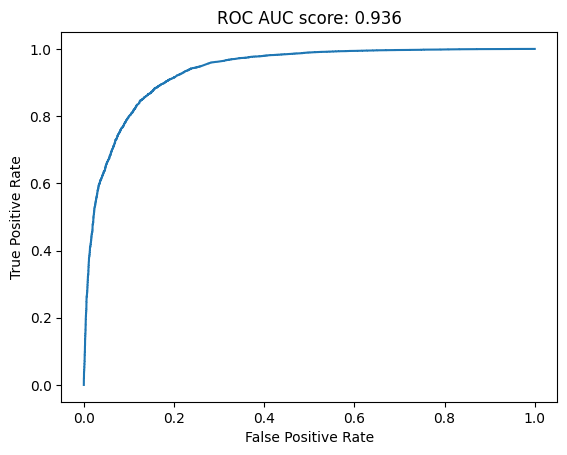

In [69]:
plot_roc_curve(true_y=y_test.values, y_prob=clf_XGBClassifier.predict_proba(X_test)[:, 1])

In [113]:
df_scores = pd.DataFrame()

df_scores.loc["xgboost", "roc auc"] = round(roc_auc_score(y_test.values, clf_XGBClassifier.predict_proba(X_test)[:, 1]),3)
df_scores.loc["multinomialnb", "roc auc"] = round(roc_auc_score(y_test.values, clf_multinomialnb.predict_proba(X_test)[:, 1]),3)
df_scores.loc["randomforestclassifier", "roc auc"] = round(roc_auc_score(y_test.values, clf_randomforestclassifier.predict_proba(X_test)[:, 1]),3)
df_scores.loc["xgboost", "f1"] = cross_val_score(clf_XGBClassifier, X_test, y_test.values, cv=3, scoring='f1_macro').mean()
df_scores.loc["multinomialnb", "f1"] = cross_val_score(clf_multinomialnb, X_test, y_test.values, cv=3, scoring='f1_macro').mean()
df_scores.loc["randomforestclassifier", "f1"] = cross_val_score(clf_randomforestclassifier, X_test, y_test.values, cv=3, scoring='f1_macro').mean()

df_scores

,roc auc,f1
xgboost,0.936,0.846099
multinomialnb,0.899,0.764917
randomforestclassifier,0.921,0.826436
